In [101]:
import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [123]:
pd.read_csv('./open/train.csv')

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [127]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

# train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
# train = train.reset_index(drop=True)
train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)]['supply(kg)'] = 0

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
# train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)
# tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
# train = train.drop(tar)

# train['timestamp'] = train['timestamp'].astype('str')
# train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
# train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
# train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

# test['timestamp'] = test['timestamp'].astype('str')
# test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
# test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
# test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

# train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
# test = test.drop(['timestamp'],axis=1) # ID

# train = train[train['price(원/kg)'] < 7500].reset_index(drop=True)
train[train['price(원/kg)'] > 7500]['price(원/kg)'] = 7500
print('Done.')

train
# test_df = pd.read_csv('test.csv')[['ID','timestamp']]

Done.


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),Isholiday,Is_Sunday
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0,0,0
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0,0,0
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0,0,0
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0,0,0
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0,0,0
...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,3,5,0,452440.0,468.0,0,0
59393,RD_F_J_20230228,2023-02-28,3,5,0,421980.0,531.0,0,0
59394,RD_F_J_20230301,2023-03-01,3,5,0,382980.0,574.0,1,0
59395,RD_F_J_20230302,2023-03-02,3,5,0,477220.0,523.0,0,0


In [128]:
train = train[['ID','timestamp','supply(kg)', 'price(원/kg)','Isholiday','Is_Sunday']]
train['item_id'] = train_df.ID.str[0:6]
train['timestamp'] = train['timestamp'].astype('str')
# test_df['item_id'] = test_df.ID.str[0:6]

In [129]:
data = TimeSeriesDataFrame(train.drop(columns=['ID']))
predictor = TimeSeriesPredictor( 
    prediction_length=28,
    target="price(원/kg)",
    eval_metric="RMSE",
)
# seed 고정
predictor.fit(data, random_seed=42)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 42,
 'target': 'price(원/kg)',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 59397 rows, 39 items (item = single time series). Average time series length is 1523.0. Data frequency is 'D'.
Global seed set to 42
AutoGluon will save models to AutogluonModels\ag-20231115_143418\
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['supply(kg)', 'Isholiday', 'Is_Sunday']

Starting t

In [130]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Naive_FULL | Skipping fit via cloning parent ...
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL
	3.28    s     = Training runtime
Fitting model: DeepAR_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Naive_FULL', 'SeasonalNaive_FULL', 'Theta_FULL', 'AutoETS_FULL', 'RecursiveTabular_FULL', 'DeepAR_FULL', 'WeightedEnsemble_FULL']
Total runtime: 3.50 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'W

{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DeepAR': 'DeepAR_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [131]:
# seed 고정
pred = predictor.predict(data, random_seed=42, )
pred

Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
TG_A_J  2023-03-04  3299.520193  1334.958821  2055.290542  2538.121776   
        2023-03-05   638.979275 -1613.333599  -839.304045  -283.181436   
        2023-03-06  3139.336725  -192.526782  1020.498279  1808.398262   
        2023-03-07  3431.070569  -188.180645  1124.648788  2021.136762   
        2023-03-08  3406.821697  -649.971214   768.654829  1758.115519   
...                         ...          ...          ...          ...   
RD_F_J  2023-03-27   504.819190  -163.349239    99.199690   257.907243   
        2023-03-28   515.072114  -199.703719    93.793427   263.474267   
        2023-03-29   509.087107  -196.628640    73.928380   244.345227   
        2023-03-30   492.266449  -264.399044    35.413277   211.091640   
        2023-03-31   484.845810  -262.884662    18.234129   203.952403   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
TG_A_J  2023-03-04  2950.985591  3322.857384  3704.774260  4108.984700   
        2023-03-05   187.838769   625.654827  1072.651510  1546.663241   
        2023-03-06  2507.838750  3133.724959  3731.280030  4391.228237   
        2023-03-07  2784.844144  3462.256718  4180.581090  4900.695876   
        2023-03-08  2589.692537  3357.924891  4106.335074  4954.127851   
...                         ...          ...          ...          ...   
RD_F_J  2023-03-27   386.236906   507.181829   627.408308   765.167328   
        2023-03-28   394.326320   520.405008   648.697755   784.873160   
        2023-03-29   381.904270   511.275104   638.594113   776.618064   
        2023-03-30   366.989159   499.343184   629.969506   769.216661   
        2023-03-31   345.588037   481.311986   618.872423   766.719029   

                            0.8          0.9  
item_id timestamp                             
TG_A_J  2023-03-04  4589.481325  5246.979951  
        2023-03-05  2100.852738  2866.978348  
        2023-03-06  5183.151079  6434.682186  
        2023-03-07  5783.842648  7006.556116  
        2023-03-08  5922.162924  7415.280456  
...                         ...          ...  
RD_F_J  2023-03-27   918.026055  1138.902576  
        2023-03-28   950.832034  1183.334873  
        2023-03-29   950.357529  1184.772872  
        2023-03-30   939.656064  1195.242120  
        2023-03-31   940.539826  1199.682750  

[1092 rows x 10 columns]

In [145]:
pred = pred['mean'].reset_index()
pred

,item_id,timestamp,mean
0,TG_A_J,2023-03-04,3299.520193
1,TG_A_J,2023-03-05,638.979275
2,TG_A_J,2023-03-06,3139.336725
3,TG_A_J,2023-03-07,3431.070569
4,TG_A_J,2023-03-08,3406.821697
...,...,...,...
1087,RD_F_J,2023-03-27,504.819190
1088,RD_F_J,2023-03-28,515.072114
1089,RD_F_J,2023-03-29,509.087107
1090,RD_F_J,2023-03-30,492.266449


In [150]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']
# submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0
# submission.to_csv('./dacon_submission.csv', index=False)
ans = []
for i in pred['timestamp'].astype('str'):
    dt = i[:4] + '-' + i[4:7] + '-' + i[7:]
    ans.append(dt)
    
submission['datestamp'] = ans
submission['regression'] = pd.read_csv('./cut_price.csv')['answer']
submission['datestamp'] = pd.to_datetime(submission['datestamp'])
submission['Is_Sunday'] = submission['datestamp'].dt.day_name() == 'Sunday'

ans = []
for tar in submission.values:
    if tar[3] == True:
        ans.append(tar[4])
    else:
        ans.append(tar[1])
        
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = ans
# submission.loc[submission['answer'] < 0.0, 'answer'] = 0.0
submission.to_csv('./reg-ts-preprocessing.csv', index=False)
submission

,ID,answer
0,TG_A_J_20230304,3299.520193
1,TG_A_J_20230305,638.979275
2,TG_A_J_20230306,3139.336725
3,TG_A_J_20230307,3431.070569
4,TG_A_J_20230308,3406.821697
...,...,...
1087,RD_F_J_20230327,504.819190
1088,RD_F_J_20230328,515.072114
1089,RD_F_J_20230329,509.087107
1090,RD_F_J_20230330,492.266449


In [156]:
sum(abs(submission['answer'] - pd.read_csv('./reg-ts28-best.csv')['answer']))

47293.723936225295

In [151]:
# ans = []
# for i in pred['timestamp'].astype('str'):
#     dt = i[:4] + '-' + i[4:7] + '-' + i[7:]
#     ans.append(dt)
    
# submission['datestamp'] = ans
# submission

In [152]:
# submission['regression'] = pd.read_csv('./cut_price.csv')['answer']
# submission['datestamp'] = pd.to_datetime(submission['datestamp'])
# submission['Is_Sunday'] = submission['datestamp'].dt.day_name() == 'Sunday'

# ans = []
# for tar in submission.values:
#     if tar[3] == True:
#         ans.append(tar[4])
#     else:
#         ans.append(tar[1])
        
# submission = pd.read_csv('./open/sample_submission.csv')
# submission['answer'] = ans
# # submission.loc[submission['answer'] < 0.0, 'answer'] = 0.0
# submission.to_csv('./reg-ts0.5.csv', index=False)
# submission

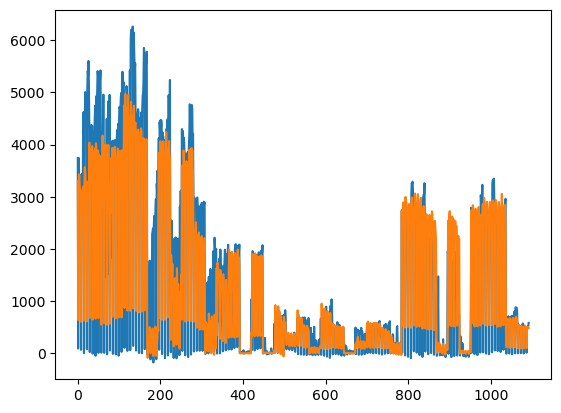

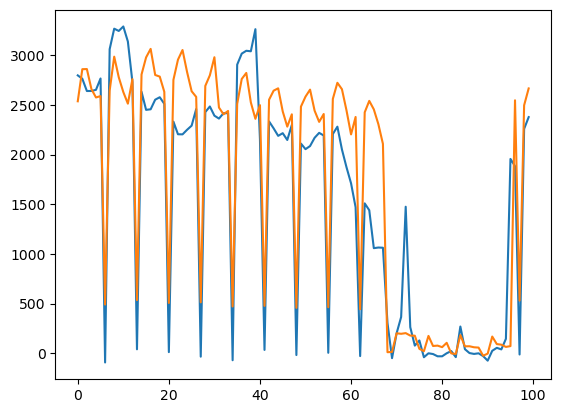

In [26]:
import matplotlib.pyplot as plt

plt.plot(pd.read_csv('./cut_price.csv')['answer'])
plt.plot([i for i in pred['mean']])
plt.show()
confirm_interval = 8
pd.read_csv('./cut_price.csv')['answer'][100*confirm_interval:100*(confirm_interval+1)].reset_index(drop=True).plot()
plt.plot([i for i in pred['mean']][100*confirm_interval:100*(confirm_interval+1)])


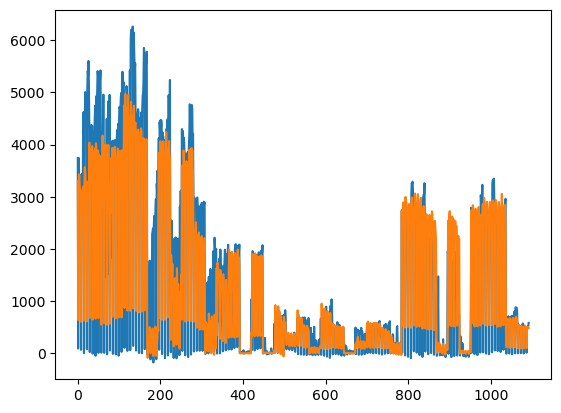

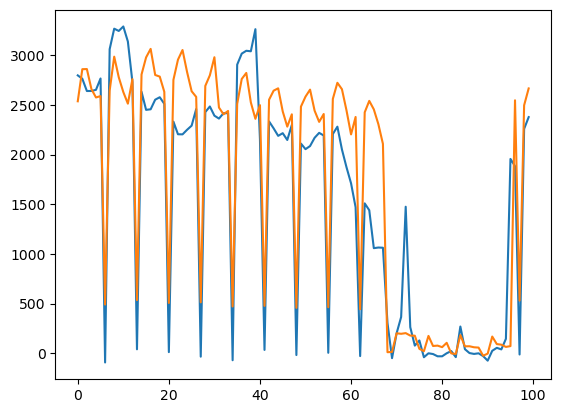

In [133]:
import matplotlib.pyplot as plt

plt.plot(pd.read_csv('./cut_price.csv')['answer'])
plt.plot([i for i in pred['mean']])
plt.show()
confirm_interval = 8
pd.read_csv('./cut_price.csv')['answer'][100*confirm_interval:100*(confirm_interval+1)].reset_index(drop=True).plot()
plt.plot([i for i in pred['mean']][100*confirm_interval:100*(confirm_interval+1)])